# BAGGING  | Machine Learning II

---
## Import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor

# others
from mltools import model_tools as MT

---
## 1. Regression problem

#### 1.1 Load the two datasets

In [3]:
# Load file with the dataset
datos_irrad = pd.read_csv('data\G04A_DATOS_IRRAD.csv', sep = ",", header = 0)
print('Dataframe:')
print(datos_irrad.head())


Dataframe:
        FECHA  IRRADH00  IRRADH03  IRRADH06   IRRADH09    IRRADH12   IRRADH15  \
0  2015-01-01       0.0       0.0       0.0  589813.00  1294089.50  468098.47   
1  2015-01-02       0.0       0.0       0.0  438244.75   989406.00  272884.66   
2  2015-01-03       0.0       0.0       0.0  543215.75  1162550.80  359685.12   
3  2015-01-04       0.0       0.0       0.0  504131.56  1229353.20  460497.50   
4  2015-01-05       0.0       0.0       0.0  502349.70  1012553.75  391783.16   

   IRRADH18  IRRADH21  ANNO  MES  DIA  DIASEM  
0       0.0       0.0  2015    1    1       3  
1       0.0       0.0  2015    1    2       4  
2       0.0       0.0  2015    1    3       5  
3       0.0       0.0  2015    1    4       6  
4       0.0       0.0  2015    1    5       0  


In [4]:
# Load the file with the target variable
datos_utilizacion = pd.read_csv('data\G04A_DATOS_UTIL.csv', sep = ",", header = 0)
print('Dataframe:')
print(datos_utilizacion.head())

Dataframe:
        FECHA   UTILH00   UTILH03   UTILH06   UTILH09   UTILH12   UTILH15  \
0  2015-01-01  0.000023  0.000008  0.053105  0.590946  0.615057  0.091254   
1  2015-01-02  0.000012  0.000004  0.048031  0.397291  0.396714  0.048448   
2  2015-01-03  0.000008  0.000000  0.049542  0.557435  0.604719  0.091748   
3  2015-01-04  0.000008  0.000000  0.014918  0.375060  0.547907  0.090296   
4  2015-01-05  0.000008  0.000008  0.016370  0.167025  0.246309  0.051614   

    UTILH18   UTILH21  ANNO  MES  DIA  DIASEM  
0  0.000008  0.000019  2015    1    1       3  
1  0.000000  0.000008  2015    1    2       4  
2  0.000004  0.000004  2015    1    3       5  
3  0.000016  0.000023  2015    1    4       6  
4  0.000004  0.000000  2015    1    5       0  


#### 1.2 Exploratory analysis

In [6]:
# Basic exploratory analysis

print('\nInfo variables:')
print(datos_irrad.describe())


Info variables:
       IRRADH00  IRRADH03       IRRADH06      IRRADH09      IRRADH12  \
count    2192.0    2192.0    2192.000000  2.192000e+03  2.192000e+03   
mean        0.0       0.0  155917.118149  1.222585e+06  1.717035e+06   
std         0.0       0.0  216484.050099  6.792104e+05  7.734269e+05   
min         0.0       0.0       0.000000  1.392584e+04  3.141285e+04   
25%         0.0       0.0       0.000000  5.870878e+05  1.121182e+06   
50%         0.0       0.0   12517.070000  1.234680e+06  1.768312e+06   
75%         0.0       0.0  288045.050000  1.865613e+06  2.417268e+06   
max         0.0       0.0  722655.940000  2.339142e+06  2.927716e+06   

           IRRADH15       IRRADH18  IRRADH21         ANNO          MES  \
count  2.192000e+03    2192.000000    2192.0  2192.000000  2192.000000   
mean   9.391827e+05   71591.939878       0.0  2017.500456     6.521898   
std    6.078704e+05  125045.898080       0.0     1.708571     3.449773   
min    3.222583e+03       0.000000    

In [ ]:

g = sns.PairGrid(datos_irrad, hue="Y")
g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

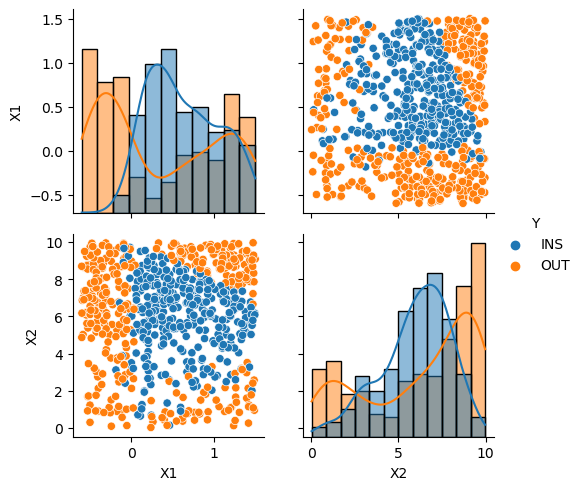

In [4]:
# Focus on interesting variables
g = sns.PairGrid(datos_irrad, vars=["X1", "X2"], hue="Y")
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

#### 1.3 Split the dataset in TR and TS

In [5]:
# Define input and output matrices
INPUTS = ['X1','X2','X3','X4','X5','X6']
OUTPUT = 'Y'
X = datos_irrad[INPUTS]
y = datos_irrad[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

### 1.4 Fit **single classification tree** (for comparison)

In [6]:
## Inputs of the model
INPUTS_DT = INPUTS

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeClassifier(criterion='gini',  # impurity measure
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
# Voy a coger el TR y probar todas las combinaciones de parámetros. mid*msl*mss = 10*10*10 = 1000 modelos
# Por cada modelo de esos 1000, voy a calcular el accuracy con 10-fold CV. Entreno con 90% y testeo con 10%.
# El accuracy es la media de los 10 valores que obtengo.
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
900 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\pipeline.py", line 420, 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeClassifier(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='accuracy')

In [7]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()
# Store the model with the best parameters into a file to use it later
MT.save_model(tree_fit.best_estimator_, 'models/DT_model.pkl')

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

##### 1.4.1 Plot the single classification tree

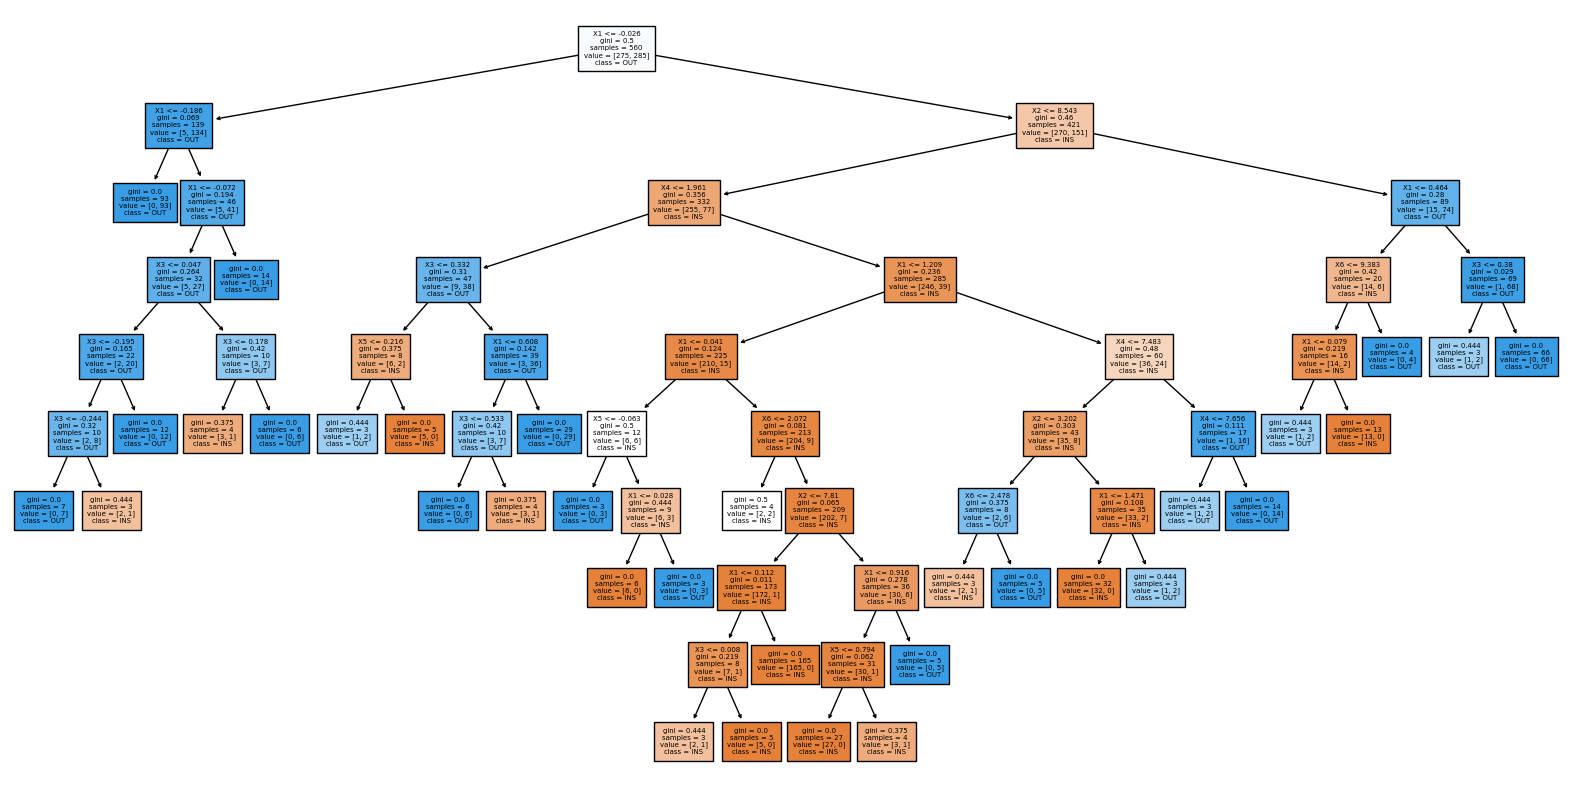

In [8]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'],
          feature_names= INPUTS_DT,
          class_names= [str(s) for s in y_train.unique()],
          fontsize=5, filled=True)
plt.show()

In [9]:
# Easy reading of the tree
print(export_text(tree_fit.best_estimator_['DT'], feature_names= INPUTS_DT))

|--- X1 <= -0.03
|   |--- X1 <= -0.19
|   |   |--- class: OUT
|   |--- X1 >  -0.19
|   |   |--- X1 <= -0.07
|   |   |   |--- X3 <= 0.05
|   |   |   |   |--- X3 <= -0.20
|   |   |   |   |   |--- X3 <= -0.24
|   |   |   |   |   |   |--- class: OUT
|   |   |   |   |   |--- X3 >  -0.24
|   |   |   |   |   |   |--- class: INS
|   |   |   |   |--- X3 >  -0.20
|   |   |   |   |   |--- class: OUT
|   |   |   |--- X3 >  0.05
|   |   |   |   |--- X3 <= 0.18
|   |   |   |   |   |--- class: INS
|   |   |   |   |--- X3 >  0.18
|   |   |   |   |   |--- class: OUT
|   |   |--- X1 >  -0.07
|   |   |   |--- class: OUT
|--- X1 >  -0.03
|   |--- X2 <= 8.54
|   |   |--- X4 <= 1.96
|   |   |   |--- X3 <= 0.33
|   |   |   |   |--- X5 <= 0.22
|   |   |   |   |   |--- class: OUT
|   |   |   |   |--- X5 >  0.22
|   |   |   |   |   |--- class: INS
|   |   |   |--- X3 >  0.33
|   |   |   |   |--- X1 <= 0.61
|   |   |   |   |   |--- X3 <= 0.53
|   |   |   |   |   |   |--- class: OUT
|   |   |   |   |   |--- X3 > 

##### 1.4.2 Compute errors of the single classification tree

In [32]:
# model predictions in training (TR) and test (TS) sets
clf = tree_fit.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)


                         TR        TS
Accuracy           0.976786  0.885714
Balanced accuracy  0.976874  0.885691


In [33]:
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=['INS','OUT'])


METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
Reference  INS  OUT
      INS  270    5
      OUT    8  277

Accuracy: 0.98
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.95
Mcnemar's Test P-Value: 0.58
Sensitivity: 0.97
Specificity: 0.98
Precision: 0.97
Recall: 0.98
Prevalence: 0.51
Detection Rate: 0.49
Detection prevalence: 0.5
Balanced accuracy: 0.98
F1 Score: 0.98
Positive label: INS


In [34]:
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=['INS','OUT'])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
Reference  INS  OUT
      INS   61    8
      OUT    8   63

Accuracy: 0.89
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.77
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.89
Specificity: 0.88
Precision: 0.88
Recall: 0.88
Prevalence: 0.51
Detection Rate: 0.45
Detection prevalence: 0.51
Balanced accuracy: 0.89
F1 Score: 0.88
Positive label: INS


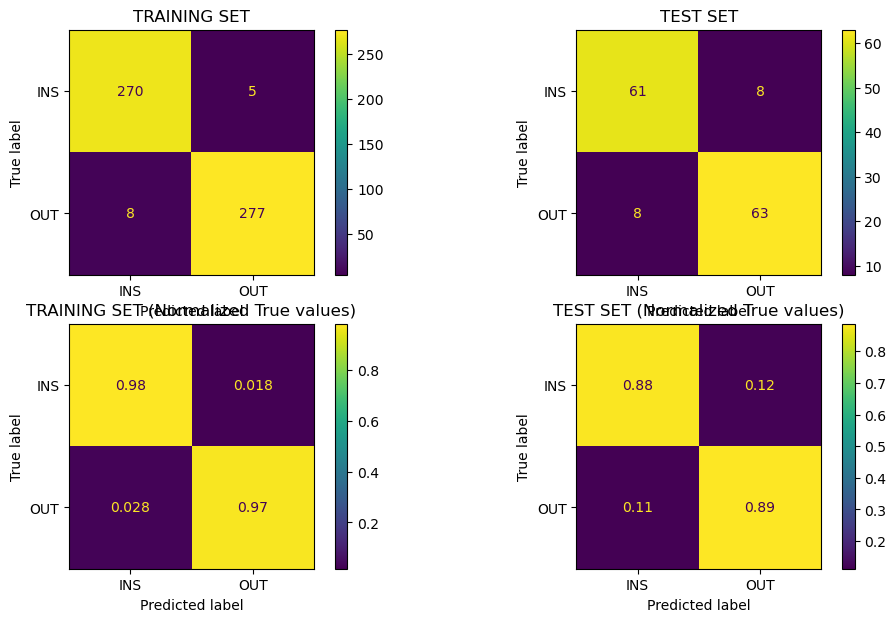

In [11]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

Confusion in TRAINING SET


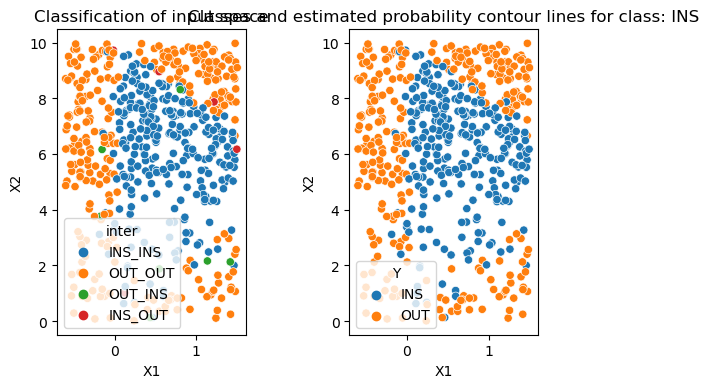

Confusion in TEST SET


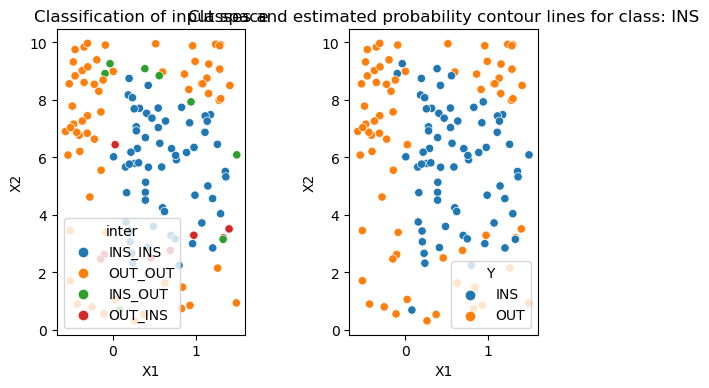

In [12]:
### Plot classification in a 2 dimensional space
print('Confusion in TRAINING SET')
CT.plot2DClass(X_train[INPUTS_DT], y_train, clf, 'X1', 'X2', 'INS', 50)
print('Confusion in TEST SET')
CT.plot2DClass(X_test[INPUTS_DT], y_test, clf, 'X1', 'X2', 'INS', 50) 

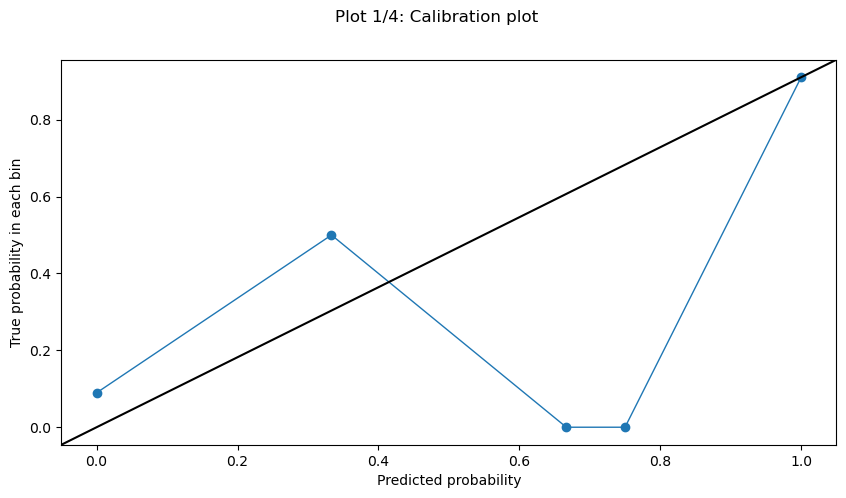

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


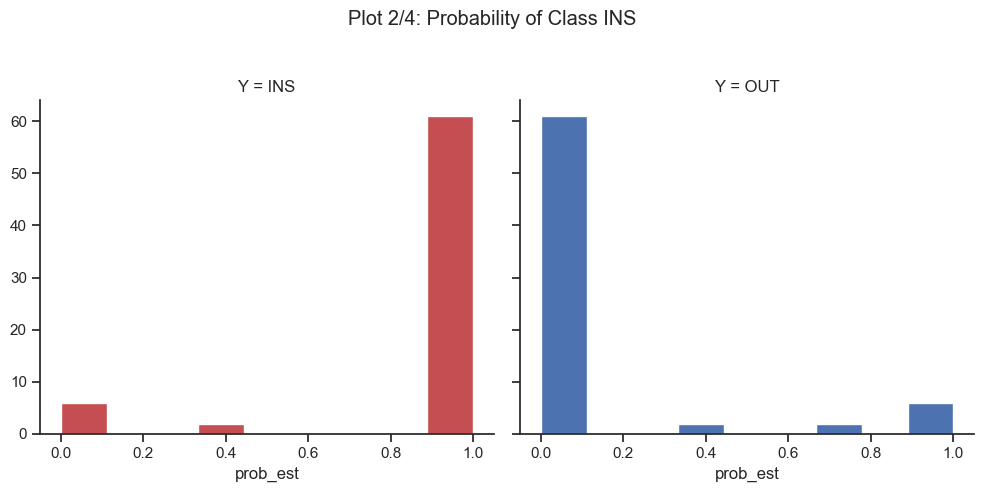

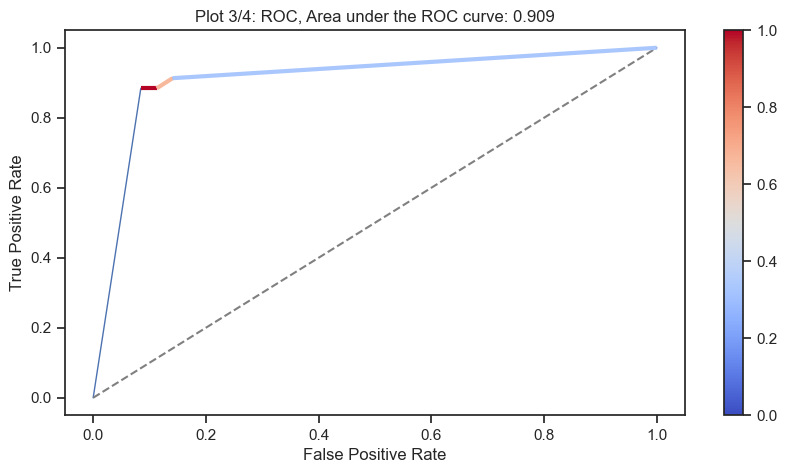

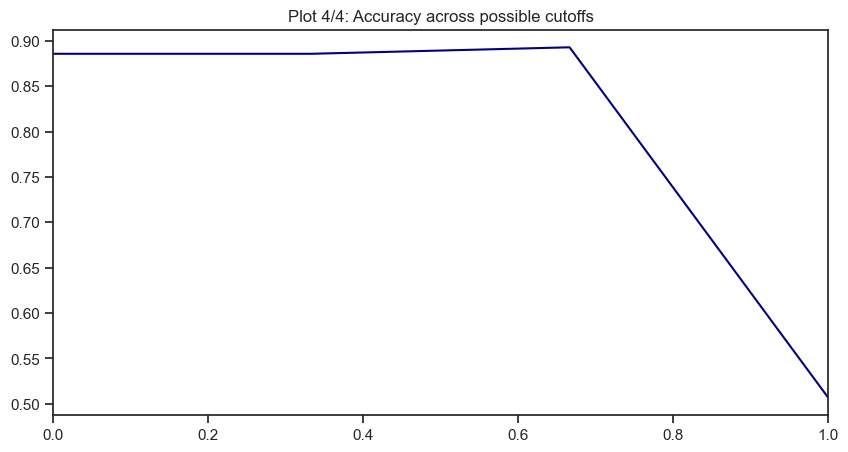

In [13]:
CT.plotClassPerformance(y_test, clf.predict_proba(X_test[INPUTS_DT]), selClass='INS')

##### 1.4.3 Importances of the inputs in the single tree

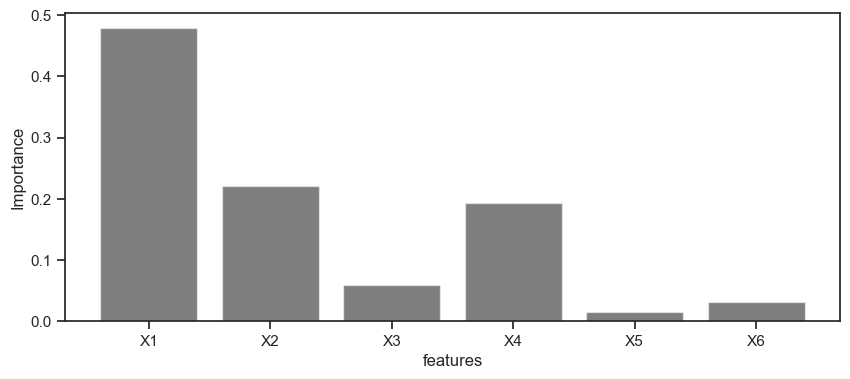

In [14]:
## Plot the variable importance of each feature
plt.figure(figsize=(10, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

Variables surrogadas: si no tenemos una variable, podemos usar otra que sea similar para hacer la predicción.

### 1.5 Fit Bagged tree

##### 1.5.1 First straightforward version (without optim hyperparameters)

In [15]:
number_estimators = 50
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=999))]) # For replication

# Lo que hace la función es entrenar 50 árboles con el mismo dataset, pero con diferentes subconjuntos de variables y observaciones.
bag_class_estim = BaggingClassifier(estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS                 
bag_class_estim.fit(X_train[INPUTS_BT], y_train)

BaggingClassifier(estimator=Pipeline(steps=[('DT',
                                             DecisionTreeClassifier(random_state=999))]),
                  n_estimators=50, random_state=0)

In [ ]:
# Save the model into the models folder
MT.save_model(bag_class_estim, 'bagged_trees')  

In [35]:
# model predictions in training (TR) and test (TS) sets
clf = bag_class_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)


                         TR        TS
Accuracy           0.998214  0.921429
Balanced accuracy  0.998182  0.921515


In [37]:

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=['INS','OUT'])



METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
Reference  INS  OUT
      INS  274    1
      OUT    0  285

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.51
Detection Rate: 0.51
Detection prevalence: 0.51
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: INS


In [38]:
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=['INS','OUT'])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
Reference  INS  OUT
      INS   64    5
      OUT    6   65

Accuracy: 0.92
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.84
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.92
Specificity: 0.93
Precision: 0.91
Recall: 0.93
Prevalence: 0.51
Detection Rate: 0.46
Detection prevalence: 0.5
Balanced accuracy: 0.92
F1 Score: 0.92
Positive label: INS


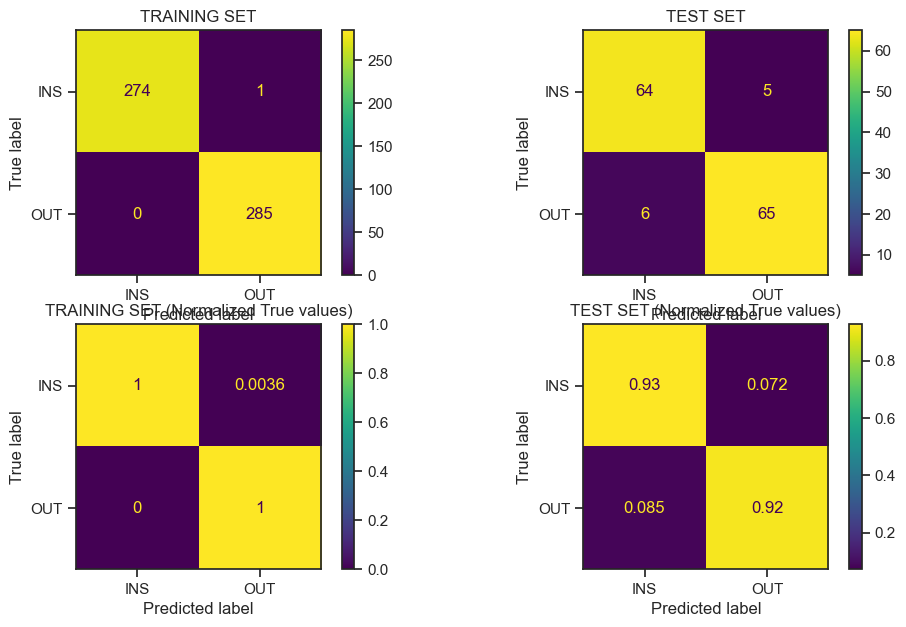

In [17]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()

Confusion in TRAINING SET


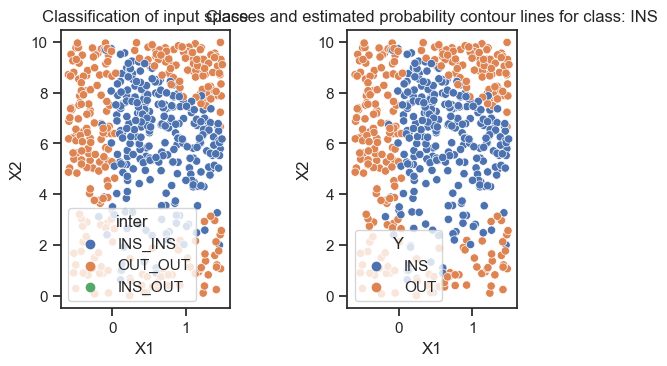

Confusion in TEST SET


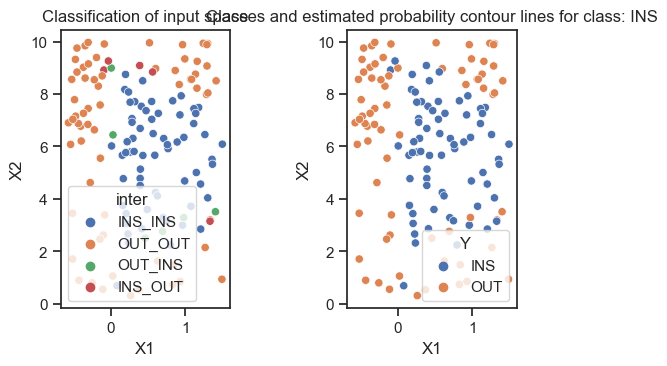

In [18]:
### Plot classification in a 2 dimensional space
print('Confusion in TRAINING SET')
CT.plot2DClass(X_train[INPUTS_DT], y_train, clf, 'X1', 'X2', 'INS', 50)
print('Confusion in TEST SET')
CT.plot2DClass(X_test[INPUTS_DT], y_test, clf, 'X1', 'X2', 'INS', 50) 

##### 1.5.2 Feature importance evaluation in bagging using "Permutation Importance"

The permutation importance of a feature is calculated as follows:
- First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. 
- Next, a feature column from the validation set is permuted and the metric is evaluated again. 
- The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

For further reading see L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

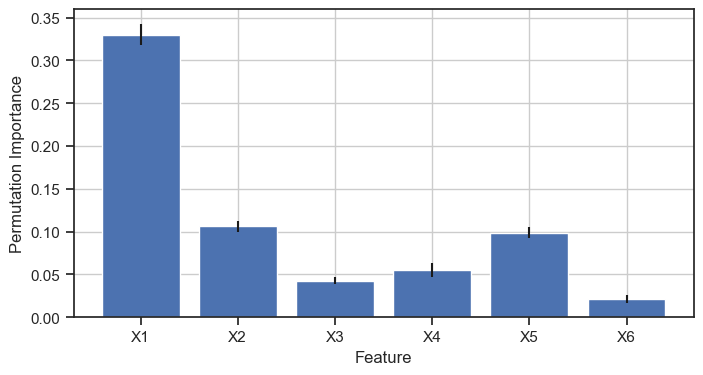

In [19]:
importances_bag_class_estim = permutation_importance(bag_class_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS_DT, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

#### 1.5.3 Plot some trees of the ensemble

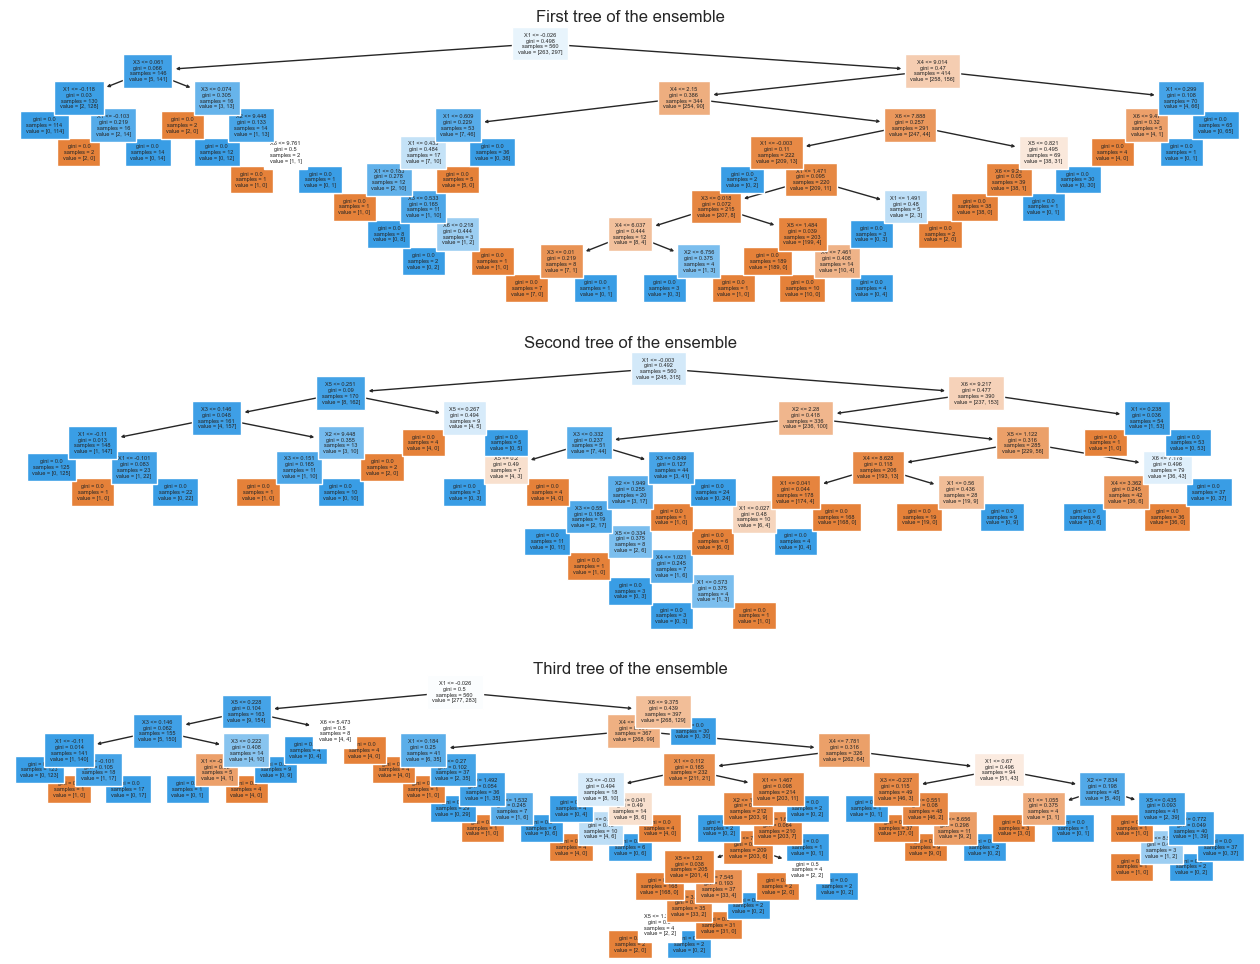

In [20]:
## Plot first trees of the ensemble
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plot_tree(bag_class_estim.estimators_[0]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'First tree of the ensemble')
plt.subplot(3,1,2)
plot_tree(bag_class_estim.estimators_[1]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Second tree of the ensemble')
plt.subplot(3,1,3)
plot_tree(bag_class_estim.estimators_[2]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Third tree of the ensemble')
plt.show()

#### 1.5.4 Variability in the ensemble

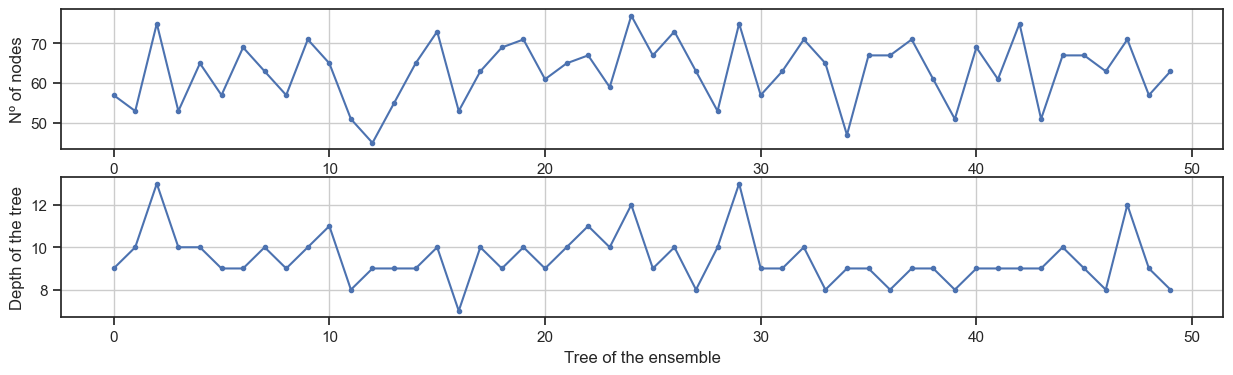

In [21]:
# number of nodes in each tree of the ensemble
node_count_trees = [t['DT'].tree_.node_count for t in bag_class_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees = [t['DT'].tree_.max_depth for t in bag_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees, '.-')
plt.ylabel('Nº of nodes')                       
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

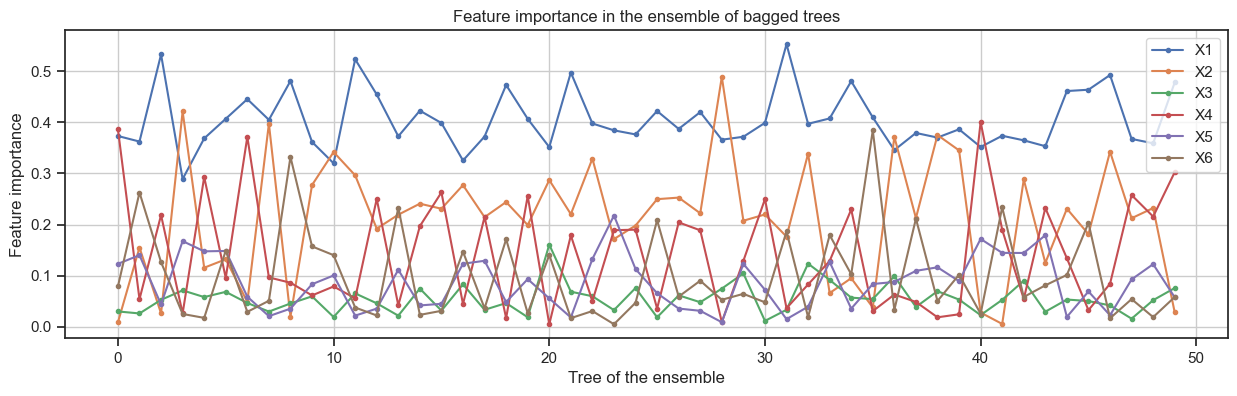

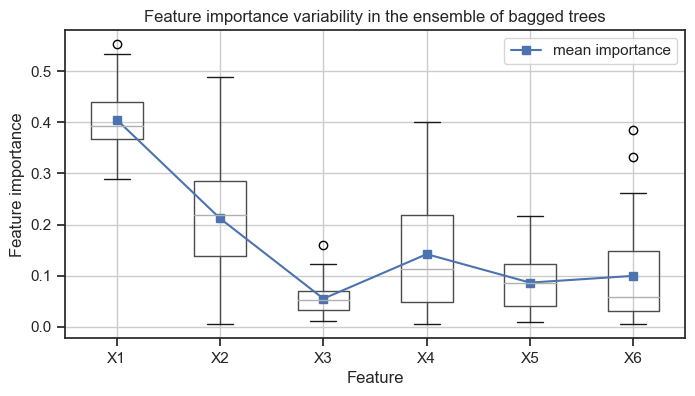

In [22]:
# feature importances of each tree in the ensemble
feature_importances_trees = [t['DT'].feature_importances_ for t in bag_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
plt.plot(feature_importances_trees, '.-', label = INPUTS_BT)
plt.ylabel('Feature importance') 
plt.xlabel('Tree of the ensemble')                                 
plt.title('Feature importance in the ensemble of bagged trees')
plt.grid()
plt.legend()
plt.show()

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(8, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

#### 1.5.5 Vote of each tree of the ensemble for each observation in the set

In [23]:
clf = bag_class_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_train_pred_trees = list([t['DT'].predict(X_train[INPUTS_DT]) for t in bag_class_estim.estimators_])

dfouts = pd.DataFrame(y_train_pred_trees)
dfouts.head()

y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()
y_test_pred_trees = list([t['DT'].predict(X_test[INPUTS_DT]) for t in bag_class_estim.estimators_])

dfouts_tr = pd.DataFrame(y_train_pred_trees)
dfouts_tr.head()
dfouts_ts = pd.DataFrame(y_test_pred_trees)
dfouts_ts.head()

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:457: UserWarning: 

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0,1,1,0,0,0,0,1,1,1,...,0,0,0,1,0,1,0,0,0,1
1,0,1,1,0,0,0,0,1,1,1,...,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,0,1,1,1,...,0,0,0,1,0,1,1,0,1,1
3,0,1,1,0,0,0,0,1,1,1,...,0,0,0,1,0,1,1,0,0,1
4,0,1,1,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,0,0,1


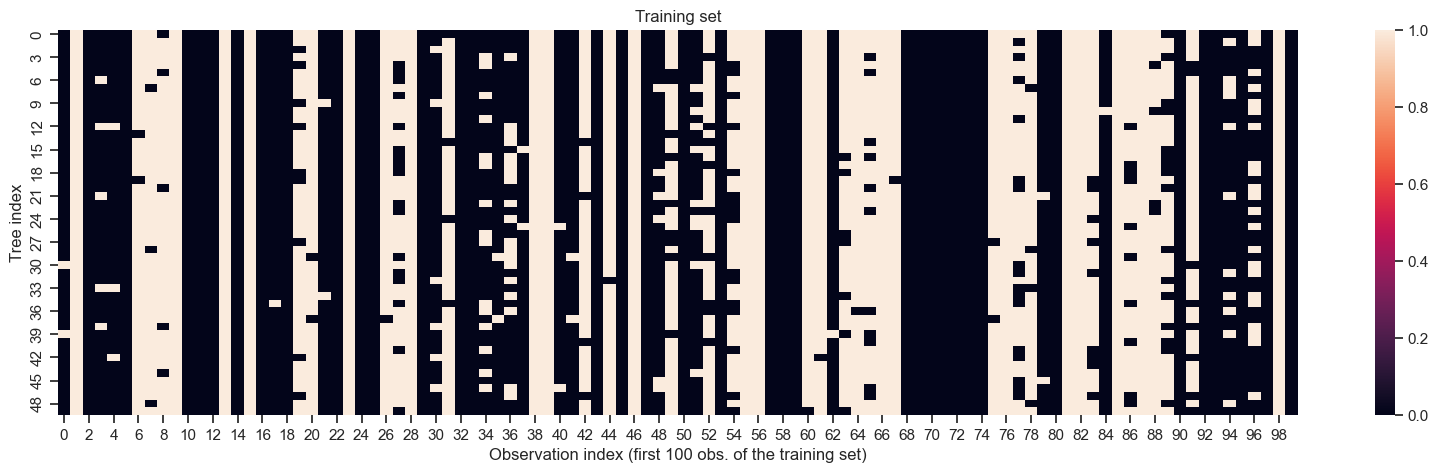

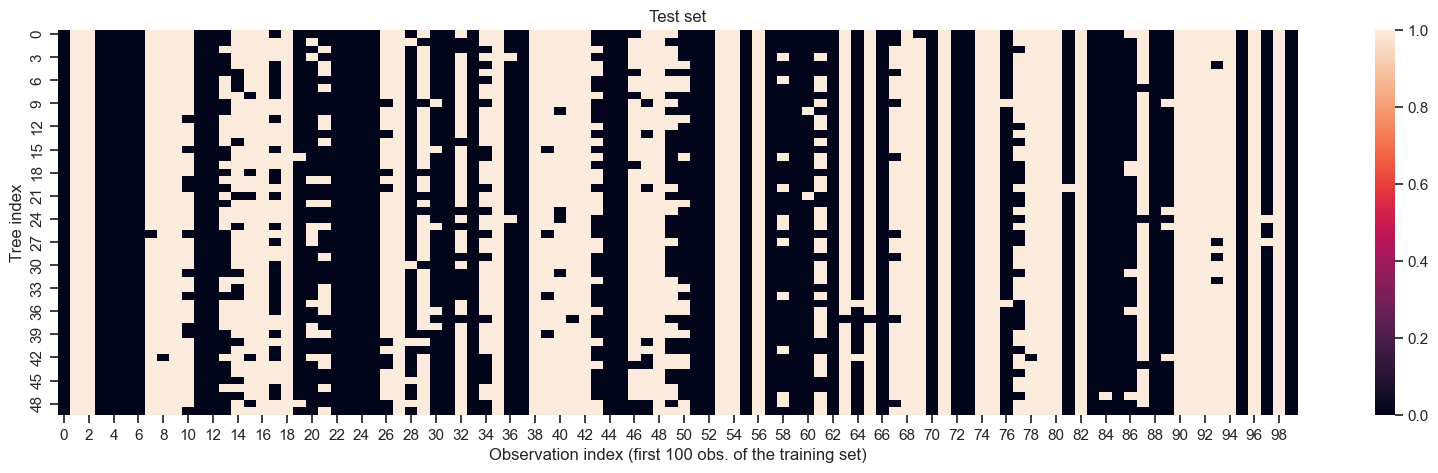

In [24]:
# plot the votes of each tree for the first 100 observations of the training set
fig = plt.figure(figsize=(20, 5))
sns.heatmap(dfouts_tr.iloc[:,:100])
plt.xlabel('Observation index (first 100 obs. of the training set)')
plt.ylabel('Tree index')
plt.title('Training set')                                 
plt.show()

fig = plt.figure(figsize=(20, 5))
sns.heatmap(dfouts_ts.iloc[:,:100])
plt.xlabel('Observation index (first 100 obs. of the training set)')
plt.ylabel('Tree index')
plt.title('Test set')                                 
plt.show()

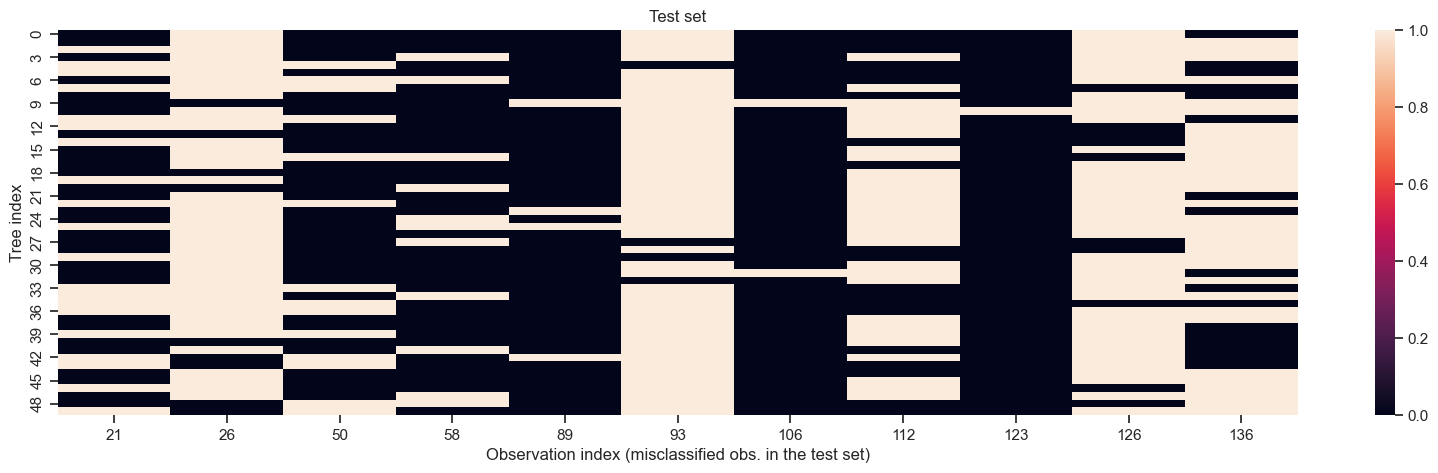

In [25]:
# focus on the misclassified observations
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
class_errors_tr = [x!=y for x,y in zip(y_train.tolist(), y_train_pred)]

y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()
class_errors_ts = [x!=y for x,y in zip(y_test.tolist(), y_test_pred)]

# plot the votes of each tree for the first 100 observations of the training set
fig = plt.figure(1,figsize=(20, 5))
sns.heatmap(dfouts_ts.iloc[:,class_errors_ts])
plt.xlabel('Observation index (misclassified obs. in the test set)')
plt.ylabel('Tree index')
plt.title('Test set')                                 
plt.show()

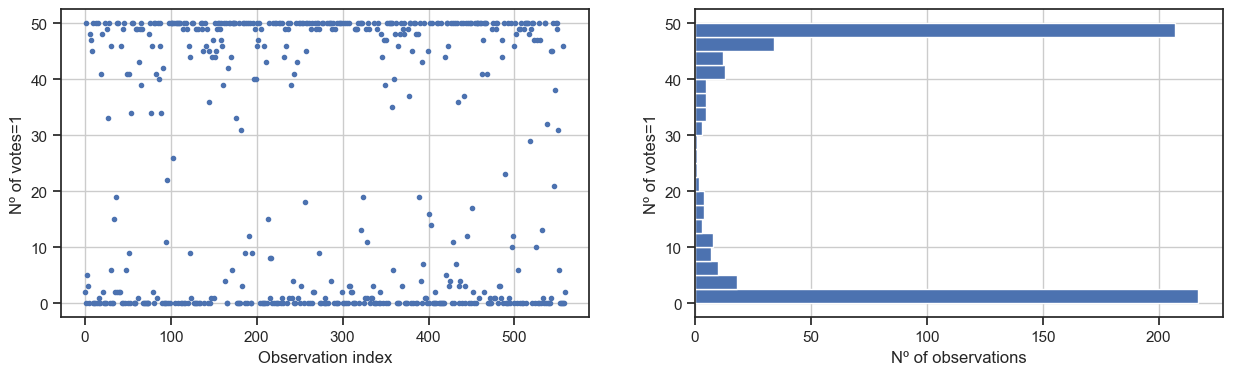

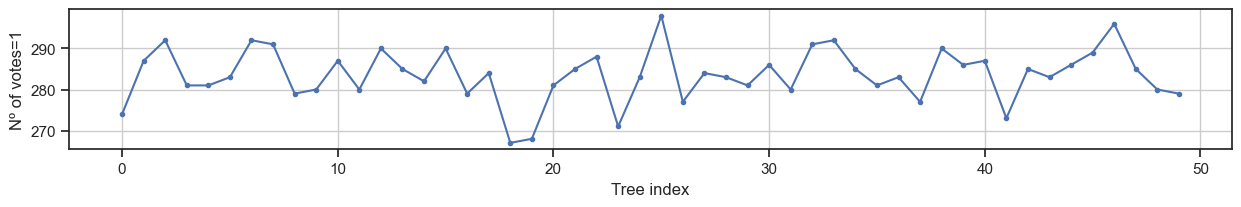

In [26]:
#number of votes = 1 for each observation
n_1s_each_obs = dfouts.sum(axis=0)

# number of ones for each tree
n_1s_each_tree = dfouts.sum(axis=1)

# plot
fig = plt.figure(figsize=(15, 4))
ax1=plt.subplot(1,2,1)
plt.plot(n_1s_each_obs, '.')
plt.ylabel('Nº of votes=1')
plt.xlabel('Observation index')                       
plt.grid()

plt.subplot(1,2,2,sharey=ax1)
plt.hist(n_1s_each_obs,bins=20,orientation='horizontal')
plt.ylabel('Nº of votes=1')
plt.xlabel('Nº of observations')
plt.grid()
plt.show()

fig = plt.figure(figsize=(15, 4))
plt.subplot(2,1,2)
plt.plot(n_1s_each_tree, '.-')
plt.ylabel('Nº of votes=1')                       
plt.xlabel('Tree index')                  
plt.grid()
plt.show()

### 1.6 Fit optimal classification bagged tree using Grid Search

In [27]:
# find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[('BT', 
                            BaggingClassifier(estimator=base_estimator,
                                              random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
bt_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingClassifier(estimator=Pipeline(steps=[('DT',
                                                                                     DecisionTreeClassifier(random_state=999))]),
                                                          random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='accuracy')

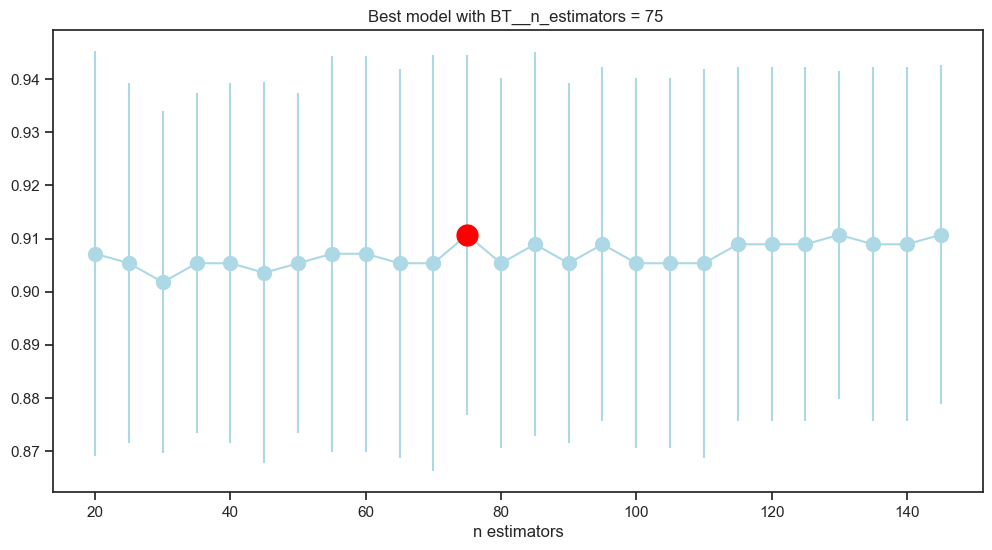

In [28]:
MT.plotModelGridError(bt_fit)

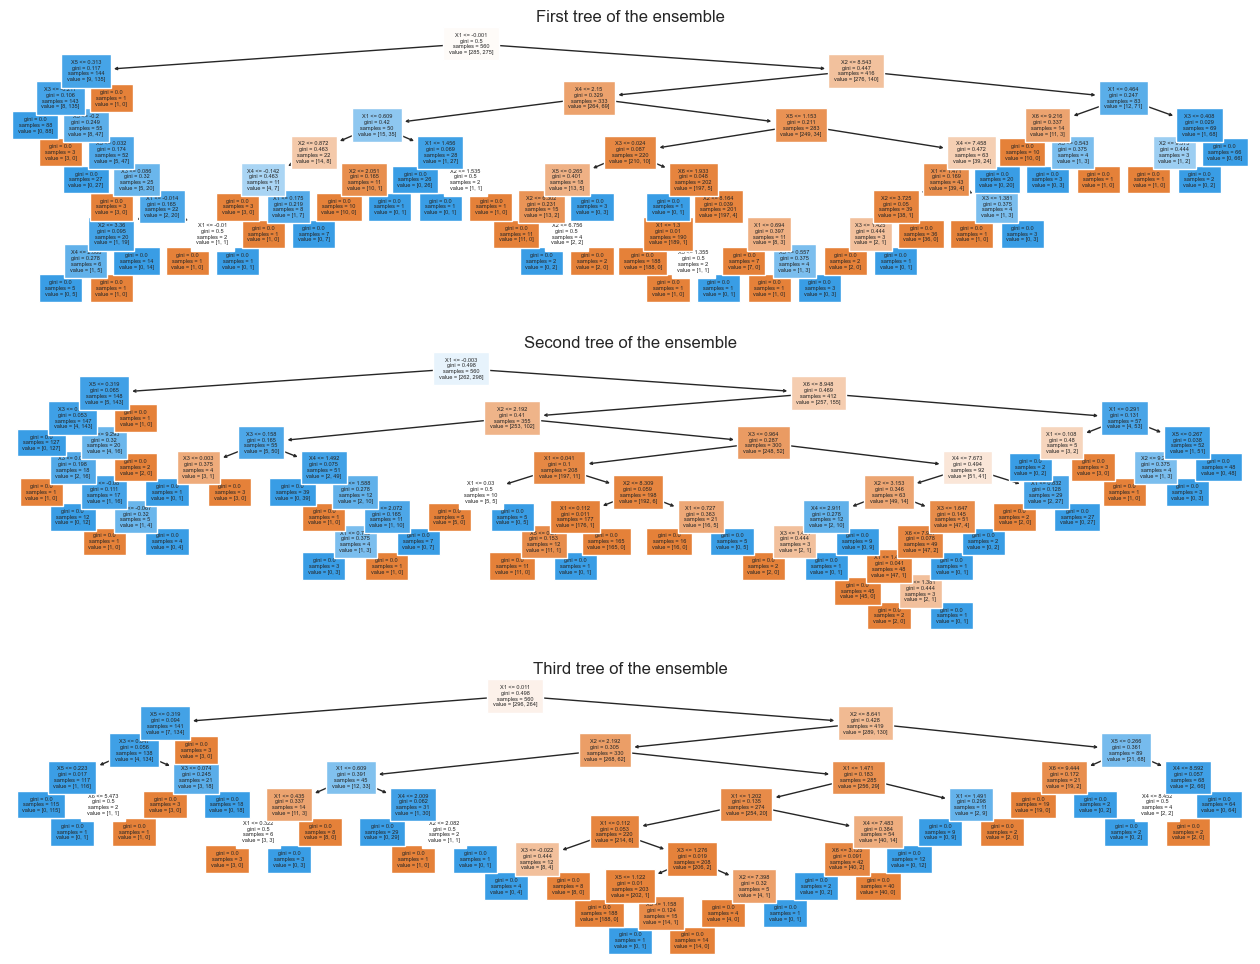

In [29]:
## Plot first trees of the ensemble
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plot_tree(bt_fit.best_estimator_['BT'].estimators_[0]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'First tree of the ensemble')
plt.subplot(3,1,2)
plot_tree(bt_fit.best_estimator_['BT'].estimators_[1]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Second tree of the ensemble')
plt.subplot(3,1,3)
plot_tree(bt_fit.best_estimator_['BT'].estimators_[2]['DT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Third tree of the ensemble')
plt.show()

In [30]:
# model predictions in training (TR) and test (TS) sets
clf = bt_fit
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=['INS','OUT'])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=['INS','OUT'])

                    TR        TS
Accuracy           1.0  0.907143
Balanced accuracy  1.0  0.907226

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
Reference  INS  OUT
      INS  275    0
      OUT    0  285

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.51
Detection Rate: 0.51
Detection prevalence: 0.51
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: INS

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
Reference  INS  OUT
      INS   63    6
      OUT    7   64

Accuracy: 0.91
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.81
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.9
Specificity: 0.91
Precision: 0.9
Recall: 0.91
Prevalence: 0.51
Detection Rate: 0.46
Detection prevalence: 0.5
Balanced accuracy: 0.91
F1 Score: 0.91
Positive label: INS


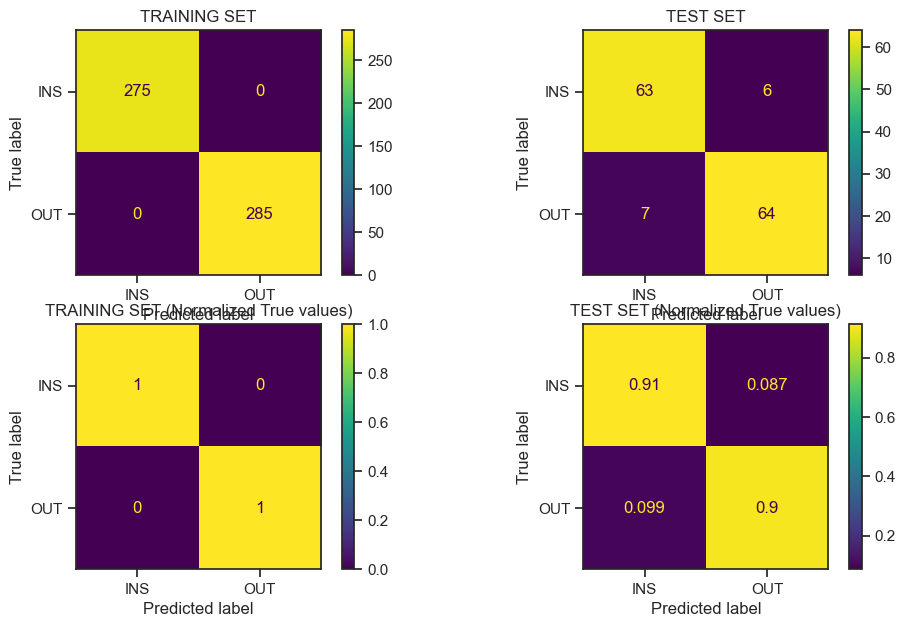

In [31]:
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax)
plt.title ('TRAINING SET')

ax = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax)
plt.title ('TEST SET')

ax = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax = ax, normalize = 'true')
plt.title ('TRAINING SET (Normalized True values)')

ax = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax = ax, normalize = 'true')
plt.title ('TEST SET (Normalized True values)')

plt.show()